In [2]:
%reload_ext autoreload
%autoreload 2

# Pipeline

In [42]:
from helpers import *

1) так как на тесте надо предсказать сумму за `31` следующих дня c разрывом в `16` дней, то, конечно, хочется это иммитировать в трейне, поэтому выбрал самый логичный способ - разбить датасет на несколько кусков (не должны пересекаться т.к. группируем по юзерам)

2) после аггрегации данных выходит, что соотношение ненулевого к нулевым ~ `500/178k`, что ломает руку, поэтому я попытался сначала отсечь руками `78k` нулей (`zero_query`), после чего осознав на практике, что любая модель оверфитнется за 0 итераций, стало понятно что нужно выровнять баланс. для этого сначала с помощью `ADASYN` генерю данные до соотношения в 2% (это x5 minority...), после чего уменьшаю majority с помощью `TomekLinks` (очищает всего 1k данных... но хотя бы немного разделит признаки) и еще больше downsample до `30%` с `ClusterCentroids` на KMeans (это ощущается немного равномернее, чем просто рандомно выбрасывать)

3) так как в распределении огромный разрыв, то очень естественно решать задачу классификации, а потом ее уточнять регрессией (типа бустинг) и в итоге выдать предсказания регрессии * вероятность классификации. тут можно так же дотюнить монотонной функцией вероятность для лучшего скора на валидации
4) с'аугментировав и сделав даунсемплинг данных, классификация, естественно, работает идеально, изменение метрики там абсолютно не нужно, другое дело в регрессии: я пытался крутить гиперпараметры и фичи, но в любом случае модели просто жестоко оверфитятся (и не учатся если совать только положительные таргеты (всего 500 объектов)), воспринимают таргет>0 как выброс и попросту выдают бред. радикальным изменением лосса я немного подвинул распределение, но модель только плюется от этого на валидации, и, все-таки, кажется в данном случае я либо промазал с фичами (которые в принципе все используют, а сезональность я не исопльзую из-за многочисленной аналитики из ориг. контеста, где ее нет), либо плохая разметка данных -- позже я попробую все одним сплитом..


In [ ]:
IS_TRAIN = False

if IS_TRAIN:
  # если train_concat_path и CT_path существуют то загрузит и сделает модели за 30 сек
  CT, clf_model, r_model, _clf_data, _r_data = train_pipeline(
    train_concat_path='data/train_concat.csv', 
    CT_path='data/CT.pkl'
    )

else:
  # если test_concat_path то сделает за 0 сек
  test_pipeline(
    test_concat_path='data/test_concat.csv',
    CT=CT, clf_model=clf_model, r_model=r_model,
    output_path='submission.csv'
    )

# Train / Val

какие есть способы разметить данные?
1) самый простой: просто взять всех юзеров до какой-то даты и после, для них посчитать таргет и готово
2) почти тоже самое: разбить трейн на несколько кусков, собрать таргеты и сконкатенировать -- чуть боле time-series способ, меньше оверфита
3) брать каждого юзера (по нескольку раз), считать walk-forward таргеты и все конкатенировать, после чего отсортировать по времени: должно получиться больше всего данных, но кажется, что это сложно, грязно и не очень понятна концеация

In [35]:
train_features = features_pipeline(train, is_train=True, gap=16)

- поймем сразу почему я отказался от одного сплита (1 способ) и выбрал 4. чем меньше сплитов, тем:
1) дольше считается
3) доля юзеров в трейне, которые так же есть и что-то купили в отложенном кусочке очень мала, соответственно, дисбаланс еще жесчтче
4) фичи куда менее повторяют поведение теста, куда более неустойчивы

In [41]:
# одного 2 пункта достаточно чтобы выбросить идею на помойку.
train_features.clf_target.value_counts()

clf_target
0    424266
1       160
Name: count, dtype: int64

- таким образом я разбиваю на 4 куска с разрывом от подсчета таргета в 10 дней (не вижу большой проблемы использовать 10<16 так как получается больше нормальных данных за минимальную цену)

- p.s. сплиты делаются в `split_features_pipeline`

# Работа с целевой метрикой

In [5]:
from helpers import *

- так как я сделал слишком удобную аугментацию, то распределение предиктов настолько хорошо, что не нужна никакая другая целевая метрика:
- p.s. взял `AUC` в качестве метрики тк дисбаланс 0.3 остался

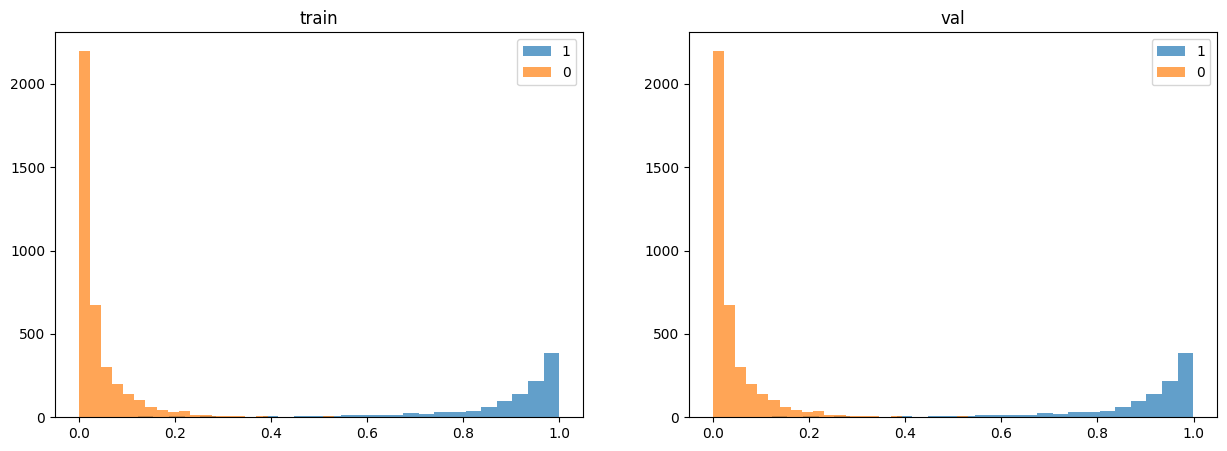

In [5]:
Image('data/train_classification_distr.png')

- с регрессией же все очень плохо:

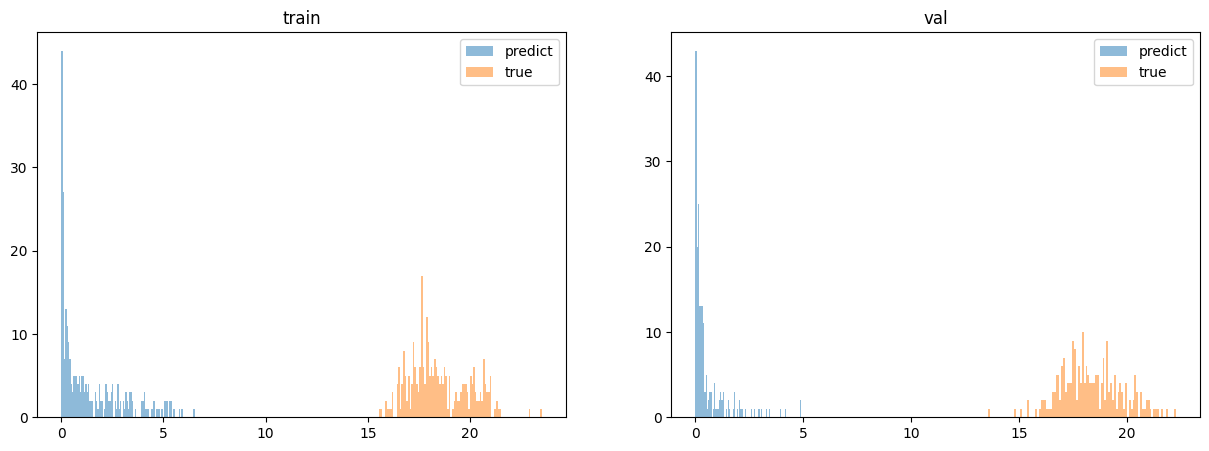

In [9]:
Image('data/train_regression_distr.png')

- фичи бесполезные настолько, что модель считает, что там где надо оутлаеры лежат. 
- я уверен что лосом такой кринж не исправить, но я попробовал though:

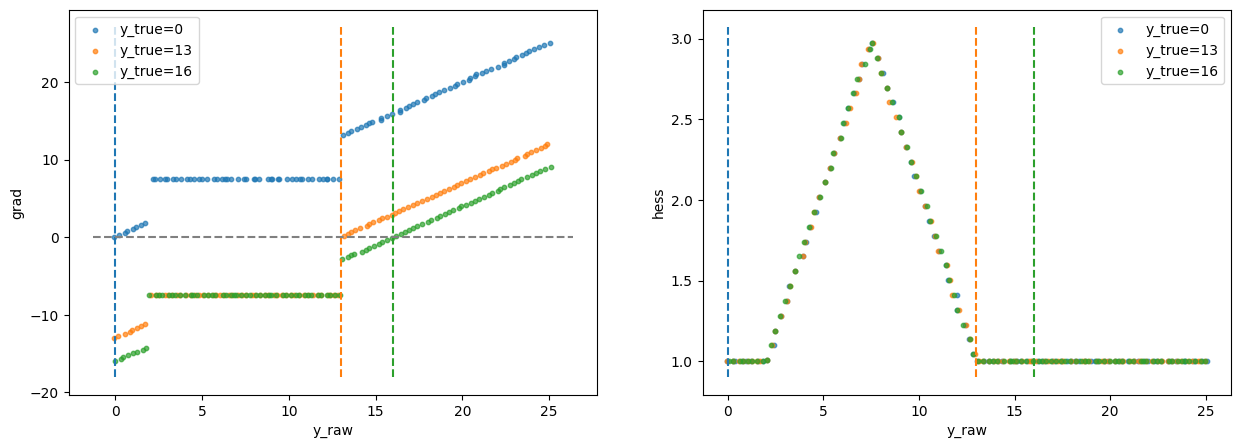

In [10]:
Image('data/custom_grad_hess.png')
# p.s. custom_fobj = custom_log_loss_grad_hess, рисовалка = plot_grad_hess

- по идее этот осиновый кол неуверенности должен хоть как-то сблизить таргет с предиктом
- но валидация все еще холодна ко мне.

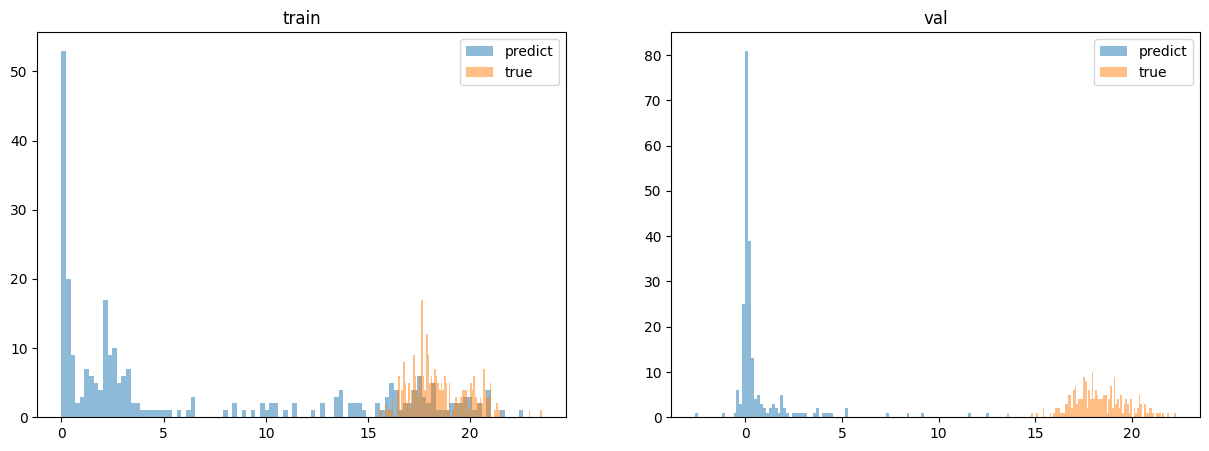

In [11]:
Image('data/train_regression_distr_new.png')

- p.s. пробовал предсказывать только положительные таргеты, там просто переобучение за 8 итераций чего угодно (всего 500 объектов)
- p.s. random forest справляется гораздо лучше по любым метрикам (в том числе меньше оверфит), но распределение оно тоже совсем не ловит  

# Подходы к задаче

- несомненно, большую часть времени пришлось потратить на работу с групбаями и всем этим ужасом по генерации фичей
- коротко о фичах: взял ВСЕ фичи у которых `get_df_info` показывал `trash_score` ниже 0.9 на обоих выборках `(target>0, target==0)`. пробовал уменьшать с shaply values и деревьев, но понял что слишком тупо так как регрессия не обучается а классификация живет в розовом мире

- - -

- дисбаланс классов "наполовину" вылечил руками, промптом выделяющим нулевые трейды:

In [ ]:
zero_query = '\
  most_freq_device_deviceCategory=="tablet" or \
  most_freq_channelGrouping=="Affiliates" or \
  most_freq_trafficSource_medium=="affiliate" or \
  most_freq_trafficSource_source in ["youtube.com", "Partners"] or \
  most_freq_networkDomain=="unknown.unknown"\
  '

пытался так же смотреть на некатегориальные, но там ничего не разделяется :(

In [ ]:
# for col in train_concat.columns.drop(not_features+cat_features):
#   plt.hist(train_concat[train_concat[col]>0].query('clf_target==1')[col], bins=100, density=True, alpha=0.5)
#   plt.hist(train_concat[train_concat[col]>0].query('clf_target==0')[col], bins=100, density=True, alpha=0.5)
#   plt.title(col)
#   plt.show()

P.S. попытался делать неглубокое sklearn.tree.DecisionTreeClassifier на onehot -- было большой ошибкой, ведь, конечно же, он везде даст 0 в листьях на маленькой глубине.... 
- поэтому использовать любые алгоритмы очень не хотелось из-за моментального оверфитинга, поэтому аггрегировал пока недоаггрегировалось

- - - 

- из уникально немного другого подхода я так же пробовал предсказывать вероятность что юзер просто вернется (`is_returned`), после чего на этом делать регрессию.
- результат: дисбаланс в классификации был заметно меньше `(6k/170k)`, но в итоге на валидации получилось то же самое! тут я понял что основная проблема в регрессии, но с ней я так и не справился: обучение регрессии на `is_returned==True` дает в точности аналогичный результат обучению на всей выборке

- - -

- подбирал число кластеров через метрику-силуэт; на 7 кластерах был более менн такой же скор как на 1-6, но хотелось брать больше, поэтому вот

In [ ]:
# For n_clusters = 5, The average  silhouette_score is : 0.937613018315093
# For n_clusters = 7, The average  silhouette_score is : 0.9224360205929947
# For n_clusters = 10, The average silhouette_score is : 0.3091684674912568
# For n_clusters = 15, The average silhouette_score is : 0.20495342713710135

- - -

из так же немного уникального:
- попытался предиктить `totals_transactionRevenue` для теста и тем самым наделать фичей `"сумма посл. транзакции", "количество транзакций", "привел ли хотя бы один прошлый визит к покупке"` итд, но там возникает опять максимально похожая проблема с тем что дисбаланс победить не удается (да и в принципе постановка такой разметки довольно плоха, если, конечно, не использовать множество всяких LSTM-based фичей)

- - -

- ну, и, напоследок, конечно, смотрел на штраф в метрике, собирался его прикрутить к f_obj, но обстоятельства вынудили немного забыть про исходную метрику...

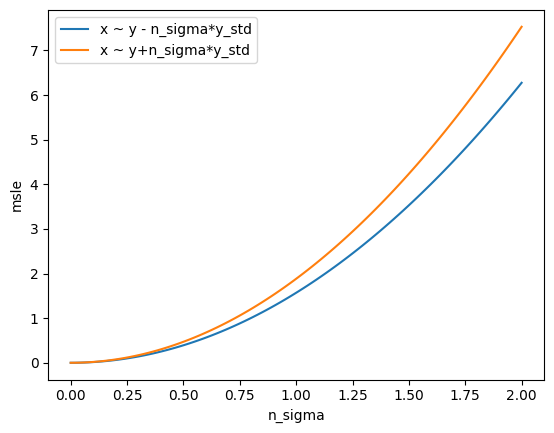

In [39]:
Image('data/fine_skew.png')

# Лишнее

зачем-то вначале убивал время совсем впустую: приблизил гладкой функцией MSLE, даже не подумав а зачем

было
$$L_{\text{MSLE}} = \frac{1}{N}\sum_{user=1}^N \Bigl[\log(1+y_{user}) - \log(1+c) \Bigr]^2 * \Bigl[1 + 0.2I\{\log(1+y_{user}) < \log(1+c)\} \Bigr] \rightarrow \min_c$$
стало
$$L_{\text{MSLE}} = \frac{1}{N}\sum_{user=1}^N \Bigl[y_{user} - c \Bigr]^2 * \Bigl[1 + 0.2I\{y_{user} < c\} \Bigr] \rightarrow \min_c$$
приближенно:
$$L_{\text{approx-MSLE}} = \frac{1}{N}\sum_{user=1}^N \Bigl[y_{user} - c \Bigr]^2 * \Bigl[1 + 0.2\sigma\{-y_{user} + c\} \Bigr] \rightarrow \min_c$$

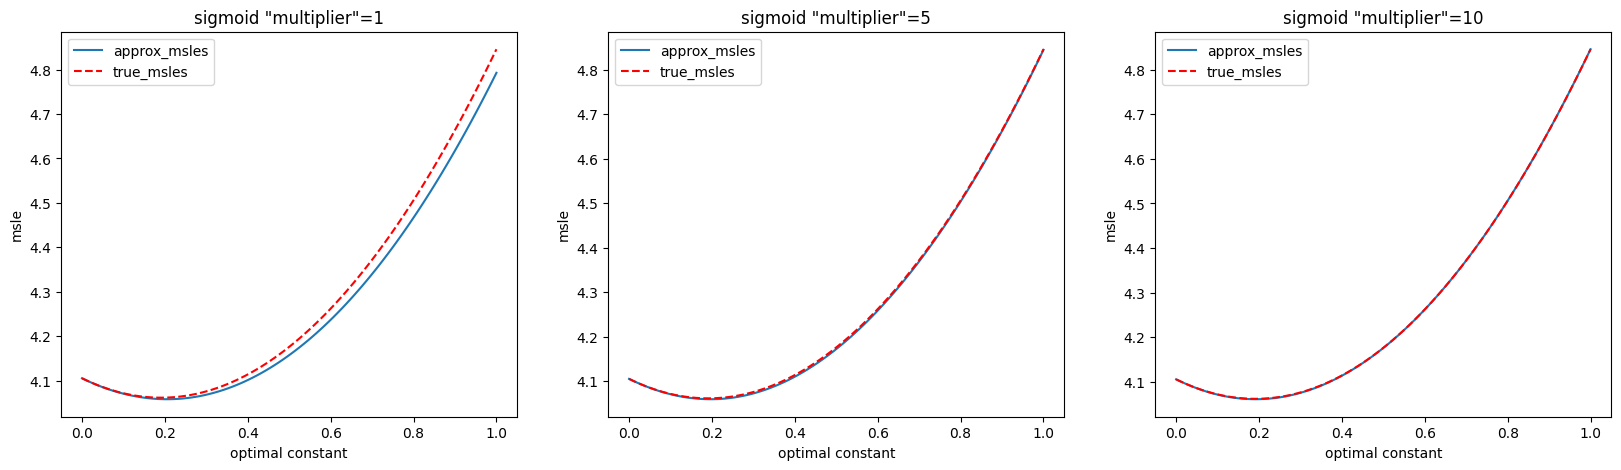

In [38]:
Image('data/sigmoid_cringe.png')